# Personalized Product Recommendation System Documentation

## Introduction

The Personalized Product Recommendation System is designed to enhance user experience by providing accurate and relevant product recommendations based on individual user preferences, past interactions, product popularity, and user similarity. This document outlines the process of creating fake data and introduces the three essential databases used in building the recommendation system.

## Creating Fake Data

To prototype and test the recommendation algorithm, we generated synthetic data to simulate user interactions, product information, and user preferences. The synthetic data includes fields such as user IDs, product IDs, interaction types, ratings, and timestamps. This fake data allows us to create a controlled environment for developing and evaluating the recommendation system.

## User Interactions Database

The user interactions database captures historical user interactions with products on the platform. It includes the following fields:

- User ID: Unique identifier for each user.
- Product ID: Unique identifier for each product.
- Interaction Type: Indicates the type of interaction (click, purchase, etc.).
- Rating: User-provided ratings for products.
- Timestamp: Date and time of the interaction.

This database serves as the foundation for training the recommendation algorithm and learning user preferences from historical interactions.

## Product Information Database

The product information database contains details about the products available on the platform. It includes the following fields:

- Product ID: Unique identifier for each product.
- Product Name: Name of the product.
- Category: Category or type of the product.
- Description: Brief description of the product.
- Additional Attributes: Other relevant features or attributes.

This database provides contextual information about products, enabling the recommendation algorithm to consider product attributes when generating recommendations.

## User Preferences Database

The user preferences database stores user attributes and characteristics that influence recommendations. It includes the following fields:

- User ID: Unique identifier for each user.
- User Attributes: Features describing user preferences, demographics, behavior, etc.

These attributes personalize the recommendation process, allowing the algorithm to tailor recommendations to individual user characteristics.

## Conclusion

The combination of creating synthetic data and utilizing the user interactions, product information, and user preferences databases forms the foundation of our Personalized Product Recommendation System. By considering historical interactions, product attributes, and user preferences, the recommendation algorithm generates accurate and relevant recommendations, enhancing user engagement and satisfaction.

---


In [42]:
import pandas as pd
import random
from faker import Faker
from datetime import datetime, timedelta

# Initialize Faker for generating fake data
fake = Faker()

# Generate products_info
num_products = 100
products_data = []
for _ in range(num_products):
    product_id = f'P{str(_ + 1).zfill(3)}'
    category = random.choice(['Electronics', 'Clothing', 'Books', 'Beauty'])
    brand = fake.company()
    avg_rating = round(random.uniform(3.5, 5.0), 2)
    num_reviews = random.randint(50, 300)
    num_purchases = random.randint(50, 200)
    num_views = random.randint(1000, 5000)
    products_data.append([product_id, category, brand, avg_rating, num_reviews, num_purchases, num_views])

products_df = pd.DataFrame(products_data, columns=['product_id', 'category', 'brand', 'avg_rating', 'num_reviews', 'num_purchases', 'num_views'])
products_df.to_csv('products_info.csv', index=False)

# Generate user_info
num_users = 200
users_data = []
for _ in range(num_users):
    user_id = f'U{str(_ + 1).zfill(3)}'
    age = random.randint(18, 60)
    gender = random.choice(['Male', 'Female'])
    state = random.choice(['Andhra Pradesh', 'Maharashtra', 'Karnataka', 'Tamil Nadu', 'Uttar Pradesh'])
    favorite_category = random.choice(['Electronics', 'Clothing', 'Books', 'Beauty'])
    users_data.append([user_id, age, gender, state, favorite_category])

users_df = pd.DataFrame(users_data, columns=['user_id', 'age', 'gender', 'state', 'favorite_category'])
users_df.to_csv('user_info.csv', index=False)

# Generate user_interactions
user_interactions_data = []
for user_id in users_df['user_id']:
    num_interactions = random.randint(3, 10)
    interaction_dates = [datetime(2023, 1, 1) + timedelta(days=random.randint(0, 180)) for _ in range(num_interactions)]
    for _ in range(num_interactions):
        product_id = random.choice(products_df['product_id'])
        interaction_type = random.choice(['Purchase', 'Click', 'Review'])
        rating = round(random.uniform(1.0, 5.0), 1) if interaction_type == 'Purchase' else '-'
        review = fake.sentence() if interaction_type == 'Review' else '-'
        interaction_date = interaction_dates.pop()
        user_interactions_data.append([user_id, product_id, interaction_type, rating, review, interaction_date])

user_interactions_df = pd.DataFrame(user_interactions_data, columns=['user_id', 'product_id', 'interaction_type', 'rating', 'review', 'interaction_date'])
user_interactions_df.to_csv('user_interactions.csv', index=False)


## Data Preparation
The raw data includes user interactions, product attributes, and user preferences. I begin by loading and cleaning the data to ensure its quality and consistency.

In [43]:
import pandas as pd

# Load interactions data
interactions_df = pd.read_csv('user_interactions.csv')

# Convert non-numeric ratings to NaN
interactions_df['rating'] = pd.to_numeric(interactions_df['rating'], errors='coerce')

# Filter out rows with NaN ratings
interactions_df = interactions_df.dropna(subset=['rating'])


## Feature Engineering
I create interaction matrices and encode categorical variables to prepare the data for model training.



In [44]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

# Define the Reader object
reader = Reader(rating_scale=(1, 5))

# Load data into Surprise's Dataset format
data = Dataset.load_from_df(interactions_df[['user_id', 'product_id', 'rating']], reader)

# Split data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)


## Model Selection and Training
I opt for a user-based collaborative filtering approach using the KNNBasic algorithm for generating recommendations.

In [45]:
from surprise import KNNBasic

# Define and train the model
sim_options = {'name': 'cosine', 'user_based': True}
model = KNNBasic(sim_options=sim_options)
model.fit(trainset)


Computing the cosine similarity matrix...
Done computing similarity matrix.


## User Interaction and Recommendations
Users are prompted to provide their user ID for receiving personalized recommendations.

In [46]:
from surprise import KNNBasic
import numpy as np

# Define and train the KNNBasic model
sim_options = {'name': 'cosine', 'user_based': True}
model = KNNBasic(sim_options=sim_options)
model.fit(trainset)

# Get user input for product recommendations
user_id = input("Enter a user ID for product recommendations: ")
num_recommendations = 15  # we can adjust the number of recommendations

# Generate personalized recommendations for the input user
user_items = interactions_df[interactions_df['user_id'] == user_id]['product_id']
user_unseen_items = [item for item in interactions_df['product_id'].unique() if item not in user_items]

# Calculate predicted ratings for unseen items
user_unseen_predictions = np.array([model.predict(user_id, item).est for item in user_unseen_items])

# Sort unseen items by predicted ratings in descending order
recommended_indices = np.argsort(user_unseen_predictions)[::-1]
recommended_products = [user_unseen_items[i] for i in recommended_indices]

# Display ranked list of recommended products
print(f"Ranked list of recommended products for user {user_id}:")
for i, product in enumerate(recommended_products[:num_recommendations], start=1):
    print(f"{i}. {product}")


Computing the cosine similarity matrix...
Done computing similarity matrix.
Enter a user ID for product recommendations: 142
Ranked list of recommended products for user 142:
1. P044
2. P039
3. P035
4. P079
5. P020
6. P090
7. P071
8. P022
9. P086
10. P023
11. P051
12. P050
13. P096
14. P040
15. P075


## Visualization and Reporting
Visualizations are created to provide insights into average product ratings, product sales trends, and user similarity matrix.

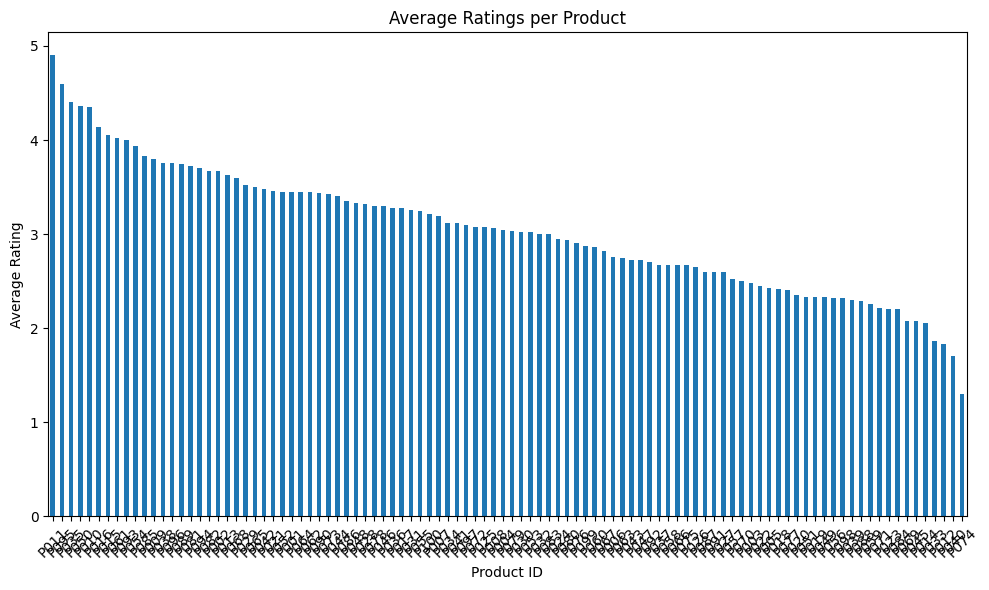

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate average ratings per product
product_likes = interactions_df.groupby('product_id')['rating'].mean()

# Plot average ratings per product
plt.figure(figsize=(10, 6))
product_likes.sort_values(ascending=False).plot(kind='bar')
plt.title('Average Ratings per Product')
plt.xlabel('Product ID')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




In [67]:
# Define a function to create a matrix-like representation
def create_matrix(predictions, num_items, threshold=3.5):
    matrix = [[0, 0], [0, 0]]  # Rows: True (above threshold), False (below threshold); Columns: Estimated (above threshold), Estimated (below threshold)

    for uid, iid, true_r, est, _ in predictions:
        true_label = 1 if true_r >= threshold else 0
        est_label = 1 if est >= threshold else 0
        matrix[true_label][est_label] += 1

    return matrix

# Make predictions on the test set
test_predictions = model.test(testset)

# Create the matrix-like representation
num_items = len(interactions_df['product_id'].unique())
matrix = create_matrix(test_predictions, num_items)

# Print the matrix-like representation
print("Confusion Matrix:")
print("                   Estimated")
print("                 Above    Below")
print(f"True Above   {matrix[1][1]:>8} {matrix[1][0]:>6}")
print(f"True Below   {matrix[0][1]:>8} {matrix[0][0]:>6}")

print()
print()
from surprise import accuracy

# Make predictions on the test set
test_predictions = model.test(testset)

# Calculate MAE and RMSE
mae = accuracy.mae(test_predictions)
rmse = accuracy.rmse(test_predictions)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")



Confusion Matrix:
                   Estimated
                 Above    Below
True Above         43     87
True Below         19    199


MAE:  0.8187
RMSE: 0.9930
Mean Absolute Error (MAE): 0.8187
Root Mean Squared Error (RMSE): 0.9930
